## STAT 628 Module 1: Body Fat Percentage Calculator  
Thurs Group 6: YUNHUI QI, SAM WATERBURY, JUNXIA ZHU

In [1]:
options(warn=-1)
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
$(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

## Introduction and Thesis Statement

The body fat percentage (BFP) of a human is a value that tells you how much of your body weight is made up of fat. In terms of overall health, it is useful that we can get a easy way to compute body fat percentage.

The goal of this project is to develop a simple, accurate and robust rule of thumb method to compute body fat percentage for men.

We fisrt clean the data by detecting possible outliers and using background information to do imputation, then used stepwise selection, lasso regression to narrow the range of potential predictors. Among the six variables selected, best subset selection was used to find the best model. We considered 2 order interactions and rations in BSS stage and found the SLR model performing best. Then we did model diagnosis and evaluated the robustness of our model. As a result, we developed a simple rule of thumb technique for estimating the body fat percentage.

## Data Description

The dataset contains 252 observations of 17 variables. Since the Siri equation describes the relation $BODYFAT\% = \frac{495}{DENSITY} - 450$, we choose BODYFAT as our response variable, and use all the rest variables except IDNO and DENSITY as our potential predictors.

## Data cleaning
In order to have a simple model, we consider linear regression model. We check the linearity using scatterplot(see code.r) and think it is appropriate to use SLR model. But SLR is sensitive to ourliers, we detect ourliers first. First, we use Siri's equation since we know there should be a linear relation between $BODYFAT$ and $DENSITY$.

In [2]:
# Packages
options(warn = -1)
suppressPackageStartupMessages(library(tidyverse))
library(ggplot2)
suppressPackageStartupMessages(library(glmnet))
library(leaps)
suppressPackageStartupMessages(library(car))
suppressPackageStartupMessages(library(reshape2))
set.seed(628)

# Open dataset
dat <- suppressMessages(read_csv("data/BodyFat.csv"))

In [3]:
# Root MSE calculator
root.mse <- function(y, yhat) {
  return(sqrt(mean((y - yhat) ^ 2)))
}

# Siri's equation for calculating body fat percentage from density
siri <- function(density) {
  return(495 / density - 450)
}

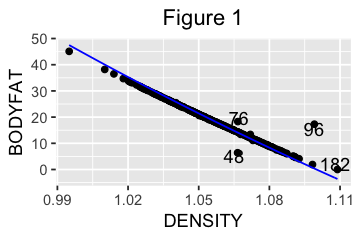

In [4]:
# Examine the difference between BODYFAT and values calculated with Siri's eq.
options(repr.plot.width=3, repr.plot.height=2)
fig1 <- ggplot(dat, aes(DENSITY, BODYFAT)) + geom_point() +
  stat_function(fun = siri, n = 101, color = "blue") +
  annotate("text", 1.065, 5, label = as.numeric(which(
    dat$DENSITY < 1.07 & dat$DENSITY > 1.06 & dat$BODYFAT > 5 & dat$BODYFAT < 10))) +
  annotate("text", 1.099, 15.4, label = as.numeric(which(
    dat$DENSITY < 1.11 & dat$DENSITY > 1.09 & dat$BODYFAT > 15 & dat$BODYFAT < 20))) +
  annotate("text", 1.108, 2, label = as.numeric(which(
    dat$DENSITY > 1.1 & dat$BODYFAT < 5))) +
  annotate("text", 1.067, 19.8, label = as.numeric(which(
    dat$DENSITY < 1.07 & dat$DENSITY > 1.06 & dat$BODYFAT > 18 & dat$BODYFAT < 20))) +
  labs(title = "Figure 1") + theme(plot.title = element_text(hjust = 0.5))
plot(fig1)

From Figure 1, three records 48, 96, 182，76 seem abnormal, so we look at the whole records to see if they should be deleted.

In [5]:
# Look at abnomal points to see if they should be deleted
dat[c(48, 76, 96, 182),]

IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
48,6.4,1.0665,39,148.50,71.25,20.6,34.6,89.8,79.5,92.7,52.7,37.5,21.9,28.8,26.8,17.9
76,18.3,1.0666,61,148.25,67.50,22.9,36.0,91.6,81.8,94.8,54.5,37.0,21.4,29.3,27.0,18.3
96,17.3,1.0991,53,224.50,77.75,26.1,41.1,113.2,99.2,107.5,61.7,42.3,23.2,32.9,30.8,20.4
182,0.0,1.1089,40,118.50,68.00,18.1,33.8,79.3,69.4,85.0,47.2,33.5,20.2,27.7,24.6,16.5


* **48**: The BODYFAT calculated by DENSITY is about 14.1%, but 6.4% seems to be a possible value which measn there may be some measurement error in density,so we just keep this bodyfat value.
* **76**: The BODYFAT calculated by DENSITY IS about 14.1%, but 18.3% seems possible because this person is 61 years old and older people may have higher percentage of fat so we keep this value. 
* **96**: The BODYFAT calculated by DENSITY is about 0.37%, which is extremely small, but other measurements are quite normal. So we think the value of DENSITY may be a wrong record and we keep the original BODYFAT value.
* **182**: We think 0% of bodyfat is impossible, and the BODYFAT calculated by DENSITY is negative, so we regard this as a wrong record. Then we try to see if there is other information which can help us recover this data record. we found ADIPOSITY measures BMI which relies on weight and height. So we first check if this is correct by using BMI calculator online and this is confirmed for most data records. So we try to find the relationship between BMI and bodyfat percentage, and we found fomula: $ Adult Body Fat \% =1.51\cdot BMI - 0.70\cdot AGE - 3.6\cdot SEX + 1.4$. For man, sex=1. Using this formula, we want to impute bodyfat percentage of 182th point with value 14.72% which is reasonable because from the other measurements, this man is a litte bit fit.


In [6]:
# Replace observation 182's bodyfat with 14.72%
dat[182, 2] <- 14.72

The second method we use is to check the boxplot on each variable. We did not include this figure here due to page limit,see code.r .

After looking at the boxplot, we found several suspicious points

* **39** : weight is 363.1 which is extremely heavy
* **42**: height is only 29.5 which is not reasonable for those males

In order to evaluate if those points are wrong measurements, we need to look at their whole records.

In [7]:
# Look at boxplot
data<- read.csv("data/BodyFat.csv", header=T,check.names=F)
data_m <- melt(data,id.vars="IDNO")
p <- ggplot(data_m, aes(x=variable, y=value),color=variable) + 
  geom_boxplot(aes(fill=factor(variable))) + 
  #  theme(axis.text.x=element_text(angle=50,hjust=0.5, vjust=0.5)) +
  theme(legend.position="none") + 
  labs(title = "Figure 2") +
  theme(plot.title = element_text(hjust = 0.5))
#p

In [8]:
# Look at abnomal points to see if they should be deleted
dat[c(39, 42),]

IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
39,33.8,1.0202,46,363.15,72.25,48.9,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
42,31.7,1.0250,44,205.00,29.50,29.9,36.6,106.0,104.3,115.5,70.6,42.5,23.7,33.6,28.7,17.4


* **39**: Although weight of this male is extremely high, values of other predictors confirm this weight is true. This record is definitely not a wrong record. It's a trade-off for us to decide whether to keep such a fat person in our model. We want our method to be precise and robust to ourliers. We will first keep this and show the reasons later.
* **42**: The $HEIGHT$ is 29.50 inches, which is almost certainly an erroneous record. But all the other measurements are normal. So we try to using bmi formula to see if we can recover his height. The formula is $BMI = 703 * Weight(lbs) / Height^2(in^2)$. Applying this formula results in height for this male is approximately 69.43 inches. 


In [9]:
# Replace observation 42's height with 69.43 inches
dat$HEIGHT[42] <- 69.43

## Variable Selection

To keep our model simple, we want to select at most four features for our final estimator. In order to identify the most predictive features, we use two methods:

* Stepwise variable selection based on AIC and BIC criteria

* LASSO regression

After identifying the most useful variables, we use best subset selection to find the best features for a model containing $p=1,2,3,4$ variables. Best subset selection is more computationally intensive, so it's better to use it after we've alrady narrowed our feature space to a few variables.

Besides, from all kinds of online bodyfat percentage calculators, we found weight, wrist, hip, forearm are mostly used variables. However, these calculator may based on their own data. It is not reasonable if we directly use them as selected predictors in our final model since we have our own data. But this provide us a way to doublecheck our variable selction process.

### Stepwise Selection

First, we perform stepwise variable selection to try and find a small number of important features. This is done using bidirectional steps with both AIC and BIC.

In [10]:
# Remove IDNO and DENSITY to do regression
dat <- dat[, c(-1, -3)]

In [11]:
lm.max <- lm(BODYFAT ~ ., data = dat)
lm.min <- lm(BODYFAT ~ 1, data = dat)
scope <- list(lower=lm.min, upper=lm.max)

# AIC
lm1 <- step(object = lm.max, scope = scope, direction = "both",
            trace = 0, k = 2) # K=2->AIC, K=log(n)->BIC
lm2 <- step(object = lm.min, scope = scope, direction = "both",
            trace = 0, k = 2) # K=2->AIC, K=log(n)->BIC

# BIC
lm3 <- step(object = lm.max, scope = scope, direction = "both",
            trace = 0, k = log(dim(dat)[1]))
lm4 <- step(object = lm.min, scope = scope, direction = "both",
            trace = 0, k = log(dim(dat)[1]))

# Found models
paste("AIC stepwise starting with full model results in:", "BODYFAT ~ AGE + WEIGHT + NECK + ABDOMEN + HIP + THIGH + FOREARM + WRIST")
#summary(lm1)$call
paste("AIC stepwise starting with empty model results in:","BODYFAT ~ ABDOMEN + WEIGHT + WRIST + FOREARM + NECK + AGE + THIGH + HIP")
#summary(lm2)$call
paste("BIC stepwise starting with full model results in:","BODYFAT ~ WEIGHT + ABDOMEN + FOREARM + WRIST")
#summary(lm3)$call
paste("BIC stepwise starting with empty model results in:","ABDOMEN + WEIGHT + WRIST + FOREARM")
#summary(lm4)$call

[1] "AIC stepwise starting with full model results in: BODYFAT ~ AGE + WEIGHT + NECK + ABDOMEN + HIP + THIGH + FOREARM + WRIST"

[1] "AIC stepwise starting with empty model results in: BODYFAT ~ ABDOMEN + WEIGHT + WRIST + FOREARM + NECK + AGE + THIGH + HIP"

[1] "BIC stepwise starting with full model results in: BODYFAT ~ WEIGHT + ABDOMEN + FOREARM + WRIST"

[1] "BIC stepwise starting with empty model results in: ABDOMEN + WEIGHT + WRIST + FOREARM"

As can be seen above, the AIC criterion tends to result in models which are too large. However, BIC results in a model containing only $ABDOMEN$, $WEIGHT$, $WRIST$, and $FOREARM$. Please notice that this result is exactly the variables used by online calculators. So we consider our method is effective to some degree. 

### LASSO Regression

Next, we use LASSO regression to find a sufficiently sparse model.

In [12]:
# Feature matrix
lasso.dat <- as.matrix(subset(dat, select = -BODYFAT))

# Cross-validated selection of lambda
cv.lasso1 <- cv.glmnet(x = lasso.dat, y = dat$BODYFAT, 
                       type.measure = 'mse', alpha = 1)

# Best lambda for each model size
lasso.results <- data.frame(p = cv.lasso1$glmnet.fit$df,
                            explained = cv.lasso1$glmnet.fit$dev.ratio,
                            lambda = cv.lasso1$glmnet.fit$lambda)
cat("Results of Lasso regression at best Lambda value for each model size:\n")
print(lasso.results[c(18, 21, 24, 33, 34, 42, 46),])

# Lasso regression using a specific lambda value chosen from above
m1 <- glmnet(lasso.dat, dat$BODYFAT, lambda = 0.31424241, alpha = 1)

# Standard error of the above model `m1`
cat("\nRoot MSE for lambda=0.314: ",
    root.mse(dat$BODYFAT, predict(m1, lasso.dat))) # = 4.149806

Results of Lasso regression at best Lambda value for each model size:
   p explained     lambda
18 1 0.6231665 1.26860203
21 2 0.6472171 0.95965091
24 3 0.6647695 0.72594072
33 4 0.7055080 0.31424241
34 5 0.7079016 0.28632598
42 6 0.7234141 0.13602804
46 8 0.7280186 0.09375885

Root MSE for lambda=0.314:  4.149806

The above table lists the $\lambda$-value which minimizes the root mean-squared error for a model containing $p=1,...,8$ features. Choosing the LASSO regression with 4 terms results in a root MSE of 4.15. The features contained in this regression are $AGE$, $HEIGHT$, $ABDOMEN$, and $WRIST$.

### Best Subset Selection

Stepwise selection and LASSO regression identified 6 variables in total:$ABDOMEN$, $WRIST$, $WEIGHT$, $FOREARM$, $AGE$, $HEIGHT$

We next perform best subset selection (BSS) to determine which of these variables should be included in a model with $p=1,2,3,4$ variables.

In [13]:
# Feature matrix containing WEIGHT, ABDOMEN, FOREARM, WRIST, AGE, HEIGHT
dat.6vars <- as.matrix(
  subset(dat, select = c(WEIGHT, ABDOMEN, FOREARM, WRIST, AGE, HEIGHT)))

# Best subset selection
best.subset <- regsubsets(x = dat.6vars, y = dat$BODYFAT, nvmax = 4,
                          method = "exhaustive")
summary(best.subset)$outmat

,WEIGHT,ABDOMEN,FOREARM,WRIST,AGE,HEIGHT
1 ( 1 ),,*,,,,
2 ( 1 ),*,*,,,,
3 ( 1 ),*,*,,*,,
4 ( 1 ),*,*,*,*,,


The results of BSS are displayed above. We can see that the results for a 4-variable model are the same as those from our stepwise selection process using the BIC criterion.

Now, we run an OLS regression for each of these four models and assess the standard error of their fits.

In [14]:
cat("p = 1  -->  sigma = ",
    summary(lm(BODYFAT ~ ABDOMEN, dat))$sigma,
    "\np = 2  -->  sigma = ",
    summary(lm(BODYFAT ~ ABDOMEN + WEIGHT, dat))$sigma,
    "\np = 3  -->  sigma = ",
    summary(lm(BODYFAT ~ ABDOMEN + WEIGHT + WRIST, dat))$sigma,
    "\np = 4  -->  sigma = ",
    summary(lm(BODYFAT ~ ABDOMEN + WEIGHT + WRIST + FOREARM, dat))$sigma,
    sep = "")

p = 1  -->  sigma = 4.537817
p = 2  -->  sigma = 4.144309
p = 3  -->  sigma = 4.081215
p = 4  -->  sigma = 4.041651

A 2-variable model is a solid improvement over a 1-variable model, but the improvements from adding a $3^{rd}$ or $4^{th}$ variable are small. This leads us to conclude that a 2-variable model containing $ABDOMEN$ and $WEIGHT$ is the best balance between accuracy and simplicity.

### Considering Interactions

We also considered interactions of these 6 variables as well. First, we generated a matrix containing of all interactions between these 6 variables and their inverses. We then performed Lasso regression as before to identify important variables. Then, using BSS, we identified the variable $\frac{HEIGHT}{ABDOMEN}$ as the most predictive variable.

However, this interaction does not provide an improvement in the accuracy of our estimator over the simpler additive model with two variables, so we do not use it.

## Final Model

Our final model takes the form:

$$ \text{(Body Fat %)}_i = \beta_0 + \beta_1 \cdot \text{ABDOMEN}_{i} + \beta_2 \cdot \text{WEIGHT}_{i} + \epsilon_i, \quad{} \epsilon_i \sim N(0,\sigma^2) $$


The coefficient estimates are shown below.

$$ BODYFAT \% = 0.91\cdot ABDOMEN(lbs) - 0.14\cdot WEIGHT(cm) - 40.27 \%$$

### Interpretation of SLR results

0. A note for multiple hypothesis testing: In this interpretation, we will talk about several hypothesis tests, which will require significance level to be adjusted. Roughly using Bonferroni method, we can still declare significance here. However, in order to be well-understood, we did not using the declaration of adjusted significance level here.

1. Coefficients: When weight is fixed, bodyfat will increase 0.91 percent if abdomen increase one centimeter. When abdomen is fixed, bodyfat will decrease 0.14 percent if weight increase one pound. The latter result may seem strange at first, but we can say this, abdomen is in fact a measure of obesity. But if abdomen is fixed and weight increases, the gain of weight is not because of fat but because of muscle which will result in low bodyfat. 

2. Confidence interval for coefficients: The 95% confidence interval for the coefficient of abdomen is  $(0.80,1.01)$, for the coefficient of weight is  $(-0.18,-0.10)$, and the intercept is $(-45.04,-35.50)$. In other words, we are 95% confident that our intervals contain the corresponding true coefficients' values.

3. Hypothesis testing for t tests: For each coefficient $ \beta_{i} $, we have t test: $H_0: \beta_1 = 0$ vs $H_1: \beta_1 \neq 0$. The associated p-value for coefficients of abdomen and intercept are less $2*10^-16$ while that of weight is $1.14*10^-11$. We can declare that there is a linear relationship between abdomen weight and body fat %. However, our conclusion carries a 5% error rate where we may have falsely declared that there is a relationship even though there truly isn't a relationship.

4. Hypothesis testing for F test: Using p value from F test which is less than 2.2*10^-16, we can conclude that our model is effective with 5% error rate.

5. $ R^2 $: Abdomen and weight explain about 70.98% of the variation in body fat %. Besides, compared with the full model which has adjusted $ R^2 $ equal to 70.75%, our model doesn't have much efficiency loss but less predictors.


In [15]:
bodyfat.model <- lm(BODYFAT ~ ABDOMEN + WEIGHT, data = dat)

## Model Evaluation and Diagnostics

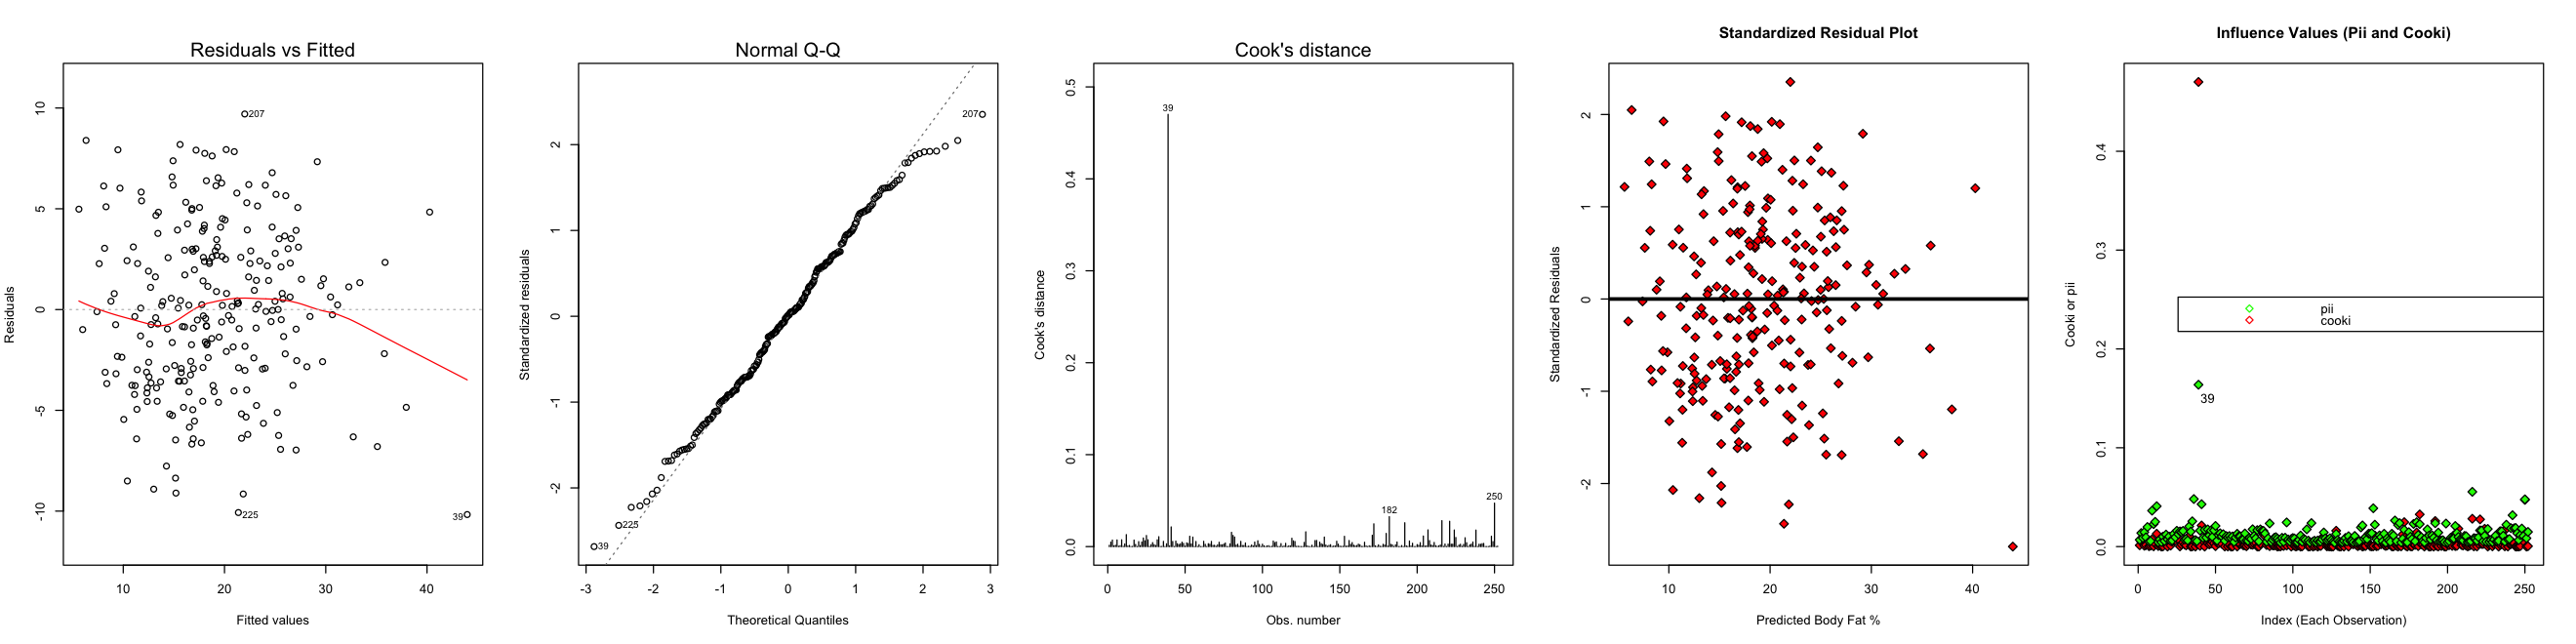

In [16]:
# Model diagnostic plots

layout(matrix(1:5, nrow = 1, byrow = TRUE))
options(repr.plot.width = 22, repr.plot.height = 5.5)
plot(bodyfat.model,which = c(1,2,4))
plot(predict(bodyfat.model), rstandard(bodyfat.model), pch = 23, bg = "red",
     cex = 1.2, xlab = "Predicted Body Fat %", ylab = "Standardized Residuals",
     main = "Standardized Residual Plot")
abline(a = 0, b = 0, col = "black", lwd = 3)

# Outlier or influential points 
pii = hatvalues(bodyfat.model)
cooki = cooks.distance(bodyfat.model)
n = dim(dat)[1]
plot(1:n, cooki, type = "p", pch = 23, bg = "red", cex=1.2,
     xlab = "Index (Each Observation)", ylab = "Cooki or pii",
     main = "Influence Values (Pii and Cooki)")
text(45, y = 0.15, labels = "39")
points(1:n, pii, type = "p", pch = 23, bg = "green", cex = 1.2)
text(45, y = 0.5, labels = "39")
legend("right", legend = c("pii", "cooki"), pch = c(23,23),
       col = c("green", "red"))



There are several important assumptions about linear regression. From diagnostic plots, we conclude:

1. Linearity: from the plot of fitted values versus residuals, we can confirm that the linear assumption is satisfied. We also checked a scatterplot to check the relationship between each predictor and response variable (you can see this plot in our full R code).
2. Additivity: seems reasonable from the interpretation of coefficients
3. Constant effects: have no reason to deny.
4. Fixed X: have no reason to deny.
5. Normally distributed errors: seems reasonable from the QQ plot.
6. Constant variance: the error terms are independent and have equal variance. 
7. Multicolinearity: the VIF value (which is 4.73 for ABDOMEN and 4.73 for weight) are all below 10, so we conclude that multicolinearity is not a problem.
7. Outliers: we first look at Cook's distance and pii values. Figure shows that 39th point needs our attention. Notice that the leverage plot shows that the 39th point is an outlier. In order to determine whether or not this point should be removed, we decided to evaluate the trade-off between robustness and precision in our model when the point is removed and kept. Please see our robustness tests part below.

## Robustness Tests and Precision
In our analysis, we want to show two aspects of robustness:

1. Trade-off between precision and robustness: the coefficients of final model do not change too much with and without 39th point.
2. Widely applied: the coefficients of model do not change too much for different bootstrap sample of original dataset.

Firstly, we fit our final model with and without 39th point to see how much the coefficients changed, the result shows a trade-off between robustness and precison. Removing the 39th point does make our final model more accurate, and this can be measured from the residual standard error (which is about 0.056 better when the point is removed).

However, we want our model to be robust; that is, we want it to be useful for a wide range of individuals. The inclusion or exclusion of the 39th point does not seem to affect the coefficients much, which indicates that our model is relatively robust to outliers. Since point 39 does not appear to be an error, we will keep it in the dataset and regard this as our final model.

We also look at robustness across different bootstrap samples. Since we round our results into to decimal points, the coefficients looks the same. But our bootstrap is sampling with replacement, we can conclude that the robustness is achieved.

In [17]:
# The 39th point is an outlier, so we decided to evaluate our model's robustness
rodata <- dat[-39,]
without <- lm(rodata$BODYFAT ~ rodata$ABDOMEN + rodata$WEIGHT)

# Use bootstrap sample to fit model and see changes of coefficients
set.seed(628)
bootdat<-sample(dat, size = dim(dat)[1], replace = T)

# Combined results
data.frame(original = round(coef(bodyfat.model), 2),without = round(coef(without), 2), bootstrap = round(coef(lm(BODYFAT ~ ABDOMEN + WEIGHT, data = bootdat)), 2))

,original,without,bootstrap
(Intercept),-40.27,-41.77,-40.27
ABDOMEN,0.91,0.90,0.91
WEIGHT,-0.14,-0.12,-0.14


## Conclusion

Our final rule of thumb is: $ BODYFAT = 0.91 \cdot ABDOMEN - 0.14 \cdot WEIGHT - 40.27$

which can be described as "90% abdomen minus 10% weight, don't forget to minus 40 percent, get your body fat!"

This estimator is easy to understand and can be quickly computed since it only uses two variables. It is robust to outlier individuals and provides relatively precise estimates of body fat percentage.

**Example Usage** : for an ordinary man with abdomen 84cm and weight 173lbs, his predicted body fat % percentage would be around 12.05%. There is a 95% probability that his body fat is between 3.85% and 20.26%.

## Strengths and Weakness of Analysis 
**Strengths:**
We believe we provide a simple, robust, accurate and precise  “rule-of-thumb” method.

1. We balanced robustness and precision while building our model.
2. We use background information to impute strange points so as not to lose observations.

**Weakness:**

1. There is p-hacking problem in our analysis, which makes it hard to use this model for inference.
2. We did not solve the multicolinearity problem in our final model; ridge regression instead of SLR does better.
3. The negative coefficient on $WEIGHT$ constrains the range of feasible weight values somewhat. If weight is very low yet the abdomen measurement is not, the estimator may overestimate the body fat percentage.

Nonetheless, we still believe that the advantages of having a simple and easy-to-use rule of thumb outweight these disadvantages.

## Contribution
The whole idea is contributed by all of us; R code is completed more by YUNHUI QI and Sam Waterbury, JUNXIA ZHU also contributed; Jupyter notebook is completed by all of us; Shiny app is mostly completed by YUNHUI QI, but Sam and JUNXIA provided many useful suggesstions; Slides are completed by all of us.

## Reference
https://bmi-calories.com/body-fat-percentage-calculator.html